# Block VQE by Qubit

Here we will split the Hilbert space into two groups, one which will be calculated classically and the other with will be calculated using block-VQE.  Instead of splitting the Hilbert space into spin-up and spin-down as we did before, here I will split the Hilbert space into general sets of qubits.  

The wavefunction is divided into classical and quantum parts
$$
    |\psi> = \sum_c \alpha_c |c>|\psi_{qc}>
$$
where $|c>$ is a basis state in the classical section and $|\psi_q>$ is the wavefunction in the quantum section.  The weights $\alpha_c$ have to be solved classically while the wavefunctions $|\psi_{qc}>$ will be updated using VQE.  

Let's do a simple X-Y-Z model with closed boundary conditions to test the algorithm.  
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$

Let us take the first $N_c$ qubits to be in the classical sector.  Then we can take energy expectation values as,
\begin{equation}
\begin{split}
&<\psi|H|\psi> = \sum_{cc'}\alpha_c\alpha_c'<\psi_{qc'}|<c'| H |c> |\psi_{qc}>=
\\
& \sum_{cc'}\alpha_c\alpha_c' \left( \sum_{i=0}^{N_c-2}  <c'|\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c><\psi_{qc'}|\psi_{qc}>  + \delta_{cc'}\sum_{i=N_c+1}^{N} <\psi_{qc'}| \ \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) |\psi_{qc}> \right) 
\\
&+ \sum_{cc'}\alpha_c\alpha_c'  \left( x<c'|X_{N_c-1}|c><\psi_{qc'}|X_{N_c}|\psi_{qc}> + y<c'|Y_{N_c-1}|c> <\psi_{qc'}|Y_{N_c}|\psi_{qc}> + z<c'|Z_{N_c-1}|c><\psi_{qc'}|Z_{N_c}|\psi_{qc}> \right) 
\end{split}
\end{equation}

Anything in the classical brakets are calculated classically while anything in the quantum brackets are calculated using quantum hardware.  Notice that some of the quantum brakets are wieghted by classical brackets.  This is not a problem.  

## Classical part

### Define Pauli Matrices

Let us define the Pauli matrices so we can do the classical calculations.

In [411]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

### Generate the states

We need a function which gives you the classical basss for a given number of qubits.

In [412]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [413]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])


### Full Hamiltoniain

Let us write the un-partitioned Hamiltonain so we can compare to it later.

In [414]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd
#pd.DataFrame(H(1,2,3,4))

### Calculating the classical brakets

We can calculate all of the classical brakets before we start VQE.  Once we have the value of each braket we simply store it as a weight for the various quantum brakets.  There are five types of classical brakets we need to calculate.

\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i\sigma}X_{i+1\sigma} + y Y_{i\sigma} Y_{i+1\sigma} + z Z_{i\sigma} Z_{i+1\sigma}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Z_{N_c-1}|c> 
\end{split}
\end{equation}

In [450]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    if Nc == 0:
        return out
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    if Nc == 0:
        return out
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    if Nc == 0:
        return out
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out



We Can use these to rewrite the Hamiltoniain.  I will shift the indicies so $ N_c \rightarrow 0 $.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}

In [451]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi


def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = tcc*Iq
    h += Bx(x,c,cc,Nc)*X(0,Nq)
    h += By(y,c,cc,Nc)*Y(0,Nq)
    h += Bz(z,c,cc,Nc)*Z(0,Nq)
    if c == cc:
        for i in range(0,Nq-1):
            h += x*Mdot([X(i,Nq),X(i+1,Nq)]) + y*Mdot([Y(i,Nq),Y(i+1,Nq)]) + z*Mdot([Z(i,Nq),Z(i+1,Nq)])
    return h
    
    
#H_quantum(1,1,1,3,2,2,2)

In [452]:
def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [453]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks
        
    

In [456]:
Blocks(1,2,3,0,2)['0,0']

[PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('XX'), coeff=1.0),
 PauliOp(Pauli('YY'), coeff=2.0),
 PauliOp(Pauli('ZZ'), coeff=3.0)]

Let us check that we can rebuild the Hamiltoniain.

In [458]:
Nc = 0
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-458-60f5d7a19d48>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-458-60f5d7a19d48>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [459]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

In [460]:
#np.linalg.eig(H_complete)

## Anzats Circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [461]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = Nq

### Diagonal Blocks

In [462]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    if len(phi_i) > 1:
        for q in range(0,Q,4):
            cir_i.cx(q,q+1)
            if q + 3 < Q:
                cir_i.cx(q+3,q+2)
    if len(phi_i) > 2:
        for q in range(1,Q,4):
            cir_i.cx(q,q+1)
            if q + 3 < Q:
                cir_i.cx(q+3,q+2)

    return cir_i

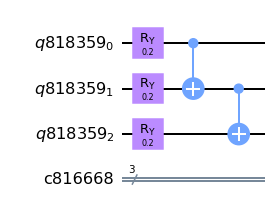

In [463]:
phi_tst = [0.2 for i in range(Nq)]
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,phi_tst)

tst.draw(output = 'mpl')

In [464]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

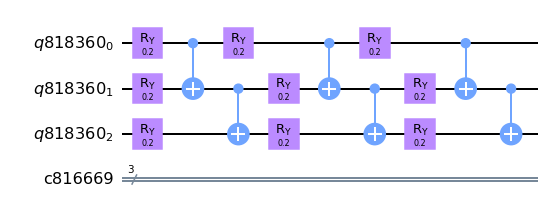

In [465]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[phi_tst,phi_tst,phi_tst])

tst.draw(output = 'mpl')

### Off Diagonal Blocks

In [466]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

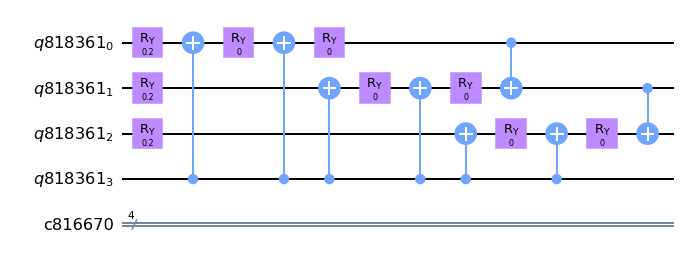

In [467]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,phi_tst,phi_tst)

tst.draw(output = 'mpl')

In [468]:
phi_tst = [0.2 for i in range(Nq)]
phi_tstb = [0.7 for i in range(Nq)]

#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,phi_tst)

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,phi_tstb)

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,phi_tst,phi_tstb)

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.69656187+0.j 0.00701232+0.j 0.00701232+0.j 0.00701232+0.j
 0.06988931+0.j 0.00070358+0.j 0.06988931+0.j 0.06988931+0.j]
B:
[0.58613658+0.j 0.07810024+0.j 0.07810024+0.j 0.07810024+0.j
 0.21395655+0.j 0.02850881+0.j 0.21395655+0.j 0.21395655+0.j]
AB:
[0.69656187+0.j 0.00701232+0.j 0.00701232+0.j 0.00701232+0.j
 0.06988931+0.j 0.00070358+0.j 0.06988931+0.j 0.06988931+0.j
 0.58613658+0.j 0.07810024+0.j 0.07810024+0.j 0.07810024+0.j
 0.21395655+0.j 0.02850881+0.j 0.21395655+0.j 0.21395655+0.j]


In [469]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

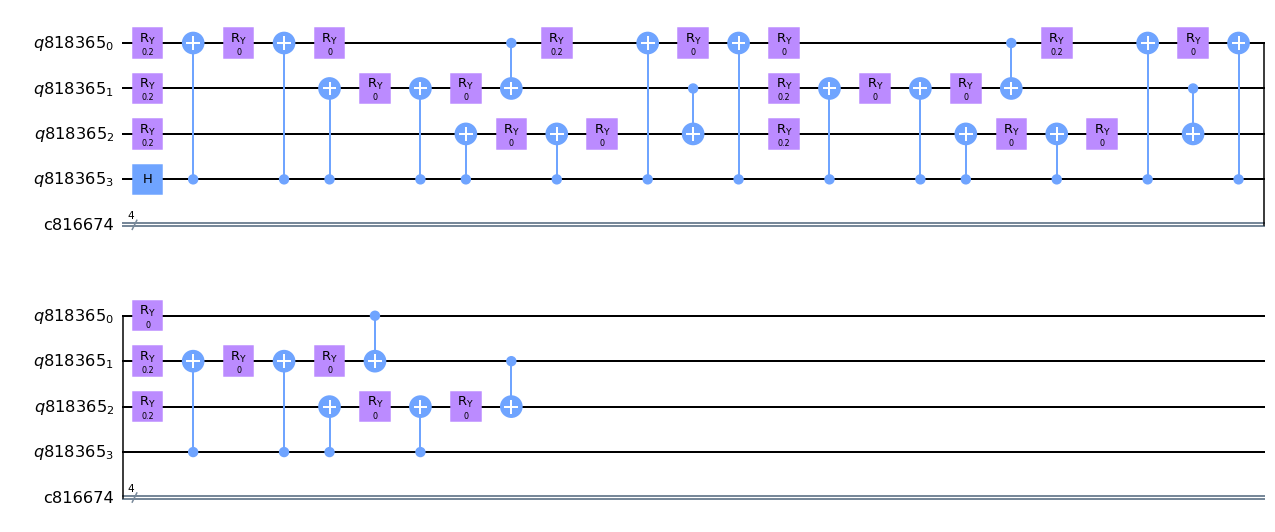

In [470]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[phi_tst,phi_tst,phi_tst],[phi_tst,phi_tst,phi_tst])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  

To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [471]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[phi_tst])
p_label = blocks['0,0'][2].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.9999999999999994+0j)
0.9999999999999996
1.0


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 
$$ <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = i<\psi^{a}|ZZ|\psi^{b}> - i<\psi^{b}|ZZ|\psi^{a}>  $$ 

$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> +  i <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{a}|ZZ|\psi^{b}> $$

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [472]:
import random
random.seed(0)

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = np.sum(block).to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (4.211562346859486+0j)
simple: (4.211562346859486+0j)
matrix: 4.211562346859485
simulator: 4.009765625


In [475]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_px = measure_pauli('X' + p_label,psi,method = method)
        E_py = measure_pauli('Y' + p_label,psi,method = method)
        E += w*(E_px + 1j*E_py)/2
    return E

block = blocks['0,0']
phi_a = phi[0]
#phi_b = phi[1]
phi_b = phi[0]
M_b = np.sum(block).to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',1/2*np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (2.105781173429743+0j)
simple: (2.105781173429743+0j)
matrix: (2.1057811734297425-1.1015494072452725e-16j)
simulator: (2.291015625-0.0517578125j)


In [476]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = method)
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = method)
    return E
            
find_E(alpha,phi,blocks)

(4.211562346859486+0j)

In [477]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(4.211562346859486+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [478]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(6+0j)

# Optimizaition

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [479]:
import copy

In [480]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

def SPSA(k_max,method = 'simple',hold = False, seed = 'False'):
    #Initalization
    if seed == 'True': np.random.seed(0)
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        #print('k = ', k ,' E_f = ', E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [481]:
out = SPSA(2000,method = 'simple',hold = True, seed = 'True')

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= -0.6623563876850386 E_A= (3.728432966594094+0j) E_B= (4.258318076742125+0j) E_f= 5.973511844525882
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= 0.6629381051578069 E_A= (5.675145604840527+0j) E_B= (5.1806539803659835+0j) E_f= 5.954504109451808
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= 2.031557079114733 E_A= (5.455219426185236+0j) E_B= (4.000665693552243+0j) E_f= 5.844268513100637
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= 1.1060593999972972 E_A= (5.794963632542914+0j) E_B= (5.025726254523647+0j) E_f= 5.799575941952028
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= -2.0197749265702716 E_A= (4.069734998461143+0j) E_B= (5.443134840576062+0j) E_f= 5.6927383407270495
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= 0.5477497910839338 E_A= (5.1725621383814+0j) E_B= (4.806900895332303+0j) E_f= 5.681786243174358
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= -2.1450926473545904

k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= 3.9287122451917478 E_A= (-4.24306544942809+0j) E_B= (-6.343786743636061+0j) E_f= -6.711382552063293
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= 1.981292528330784 E_A= (-5.240868639487818+0j) E_B= (-6.2983237906537095+0j) E_f= -6.775208694732612
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= -1.3043440174479155 E_A= (-6.988046056915463+0j) E_B= (-6.293157521034033+0j) E_f= -6.817647905755539
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= -4.5083424586604 E_A= (-7.697590462810221+0j) E_B= (-5.300063363658101+0j) E_f= -7.2092696108491685
k= 57 c_k= 0.26543229614067565 a_k= 0.021410938936572577 g= 1.0628512451393783 E_A= (-6.703570401871209+0j) E_B= (-7.267800494777852+0j) E_f= -7.236690232396058
k= 58 c_k= 0.26497441264651617 a_k= 0.02134820365090901 g= -2.766439041418261 E_A= (-7.098524371725951+0j) E_B= (-5.632453251481561+0j) E_f= -7.355599658857214
k= 59 c_k= 0.2645249951151027 a_k= 0.021

k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= -0.023247352862737165 E_A= (-7.723569062782973+0j) E_B= (-7.711968054600819+0j) E_f= -8.221511580534091
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= 0.5131082664330396 E_A= (-7.039097615847754+0j) E_B= (-7.294910962352114+0j) E_f= -8.221455125607157
k= 108 c_k= 0.24904619740500722 a_k= 0.01913308782851349 g= -0.18372425458712083 E_A= (-7.623549511892661+0j) E_B= (-7.5320378579406775+0j) E_f= -8.219897048086295
k= 109 c_k= 0.24881658787426822 a_k= 0.019100932677229843 g= -0.2927253936251636 E_A= (-7.70866700065671+0j) E_B= (-7.56299713340478+0j) E_f= -8.221101518389968
k= 110 c_k= 0.24858926511170829 a_k= 0.019069097746241874 g= 0.18806687909983266 E_A= (-7.591718084657475+0j) E_B= (-7.685220899192035+0j) E_f= -8.22156140760894
k= 111 c_k= 0.24836418604633714 a_k= 0.019037577239396412 g= 0.5777646549378952 E_A= (-7.1987381686299745+0j) E_B= (-7.485730265129961+0j) E_f= -8.22128653254034
k= 112 c_k= 0.248141308793

k= 160 c_k= 0.2394255963693599 a_k= 0.01778843684169224 g= -0.39836996244947337 E_A= (-7.775598731356846+0j) E_B= (-7.584838799686636+0j) E_f= -8.221955771979134
k= 161 c_k= 0.23927590904754018 a_k= 0.017767600739695997 g= -0.5486470782737312 E_A= (-7.620826091567455+0j) E_B= (-7.358270034767007+0j) E_f= -8.22496709731984
k= 162 c_k= 0.2391272356058773 a_k= 0.017746909621532535 g= 0.14332683943140304 E_A= (-7.203823031658233+0j) E_B= (-7.272369733460951+0j) E_f= -8.224313740170478
k= 163 c_k= 0.23897956301976508 a_k= 0.017726361649006185 g= -0.006520525562086705 E_A= (-7.569728077594827+0j) E_B= (-7.566611532895854+0j) E_f= -8.224309694757022
k= 164 c_k= 0.23883287851005275 a_k= 0.017705955017621747 g= -0.04160172176044083 E_A= (-7.83962457126532+0j) E_B= (-7.819752853347279+0j) E_f= -8.22425529471776
k= 165 c_k= 0.238687169536964 a_k= 0.01768568795577825 g= 0.03137020263032866 E_A= (-7.822860349316146+0j) E_B= (-7.8378356790634145+0j) E_f= -8.224209322434582
k= 166 c_k= 0.238542423794

k= 215 c_k= 0.23242356724141247 a_k= 0.016818769090660084 g= 0.05323797483521739 E_A= (-7.247143125024784+0j) E_B= (-7.271890645072603+0j) E_f= -8.223237253540697
k= 216 c_k= 0.23231516379006265 a_k= 0.016803850421661933 g= 0.5056141937298135 E_A= (-7.354970740485921+0j) E_B= (-7.5898944289477654+0j) E_f= -8.221736091357537
k= 217 c_k= 0.23220730895890848 a_k= 0.016789010475567686 g= 0.034240363619588356 E_A= (-7.60329720218364+0j) E_B= (-7.619198927571398+0j) E_f= -8.221756225810658
k= 218 c_k= 0.2320999974738524 a_k= 0.01677424849441828 g= -0.5719444870227028 E_A= (-7.686895647028155+0j) E_B= (-7.421399019041849+0j) E_f= -8.221270498901934
k= 219 c_k= 0.2319932241352903 a_k= 0.016759563730821866 g= -0.5784300889054487 E_A= (-7.98083908119798+0j) E_B= (-7.712455358673905+0j) E_f= -8.223074307029432
k= 220 c_k= 0.23188698381672643 a_k= 0.016744955447761316 g= -0.4906275230082455 E_A= (-7.715883804920532+0j) E_B= (-7.488343531944825+0j) E_f= -8.22271133331556
k= 221 c_k= 0.2317812714634

k= 267 c_k= 0.22741461791463288 a_k= 0.01613306933804582 g= 0.17803626803930134 E_A= (-7.796185096338383+0j) E_B= (-7.877161196080593+0j) E_f= -8.220962676949021
k= 268 c_k= 0.22732908873973287 a_k= 0.016121429910697285 g= -0.17214680748040104 E_A= (-7.5290186664592795+0j) E_B= (-7.450750712711332+0j) E_f= -8.221086329584121
k= 269 c_k= 0.22724390891616403 a_k= 0.016109840479605935 g= 0.05524929333766974 E_A= (-7.307185331496008+0j) E_B= (-7.332295462261824+0j) E_f= -8.22141609397908
k= 270 c_k= 0.22715907573097813 a_k= 0.016098300652605466 g= 0.27110738424205044 E_A= (-7.597930085737593+0j) E_B= (-7.7210990913941275+0j) E_f= -8.220324886676739
k= 271 c_k= 0.2270745865022079 a_k= 0.01608681004198741 g= 0.14407184378665716 E_A= (-7.61617138240364+0j) E_B= (-7.681601491112572+0j) E_f= -8.219535254871282
k= 272 c_k= 0.22699043857840095 a_k= 0.016075368264434862 g= -0.17295705517707954 E_A= (-7.6773905092363455+0j) E_B= (-7.5988713136165975+0j) E_f= -8.220009776376571
k= 273 c_k= 0.2269066

k= 321 c_k= 0.22323719056187072 a_k= 0.015567585137511988 g= 0.3712518175234582 E_A= (-7.584154410445253+0j) E_B= (-7.749908835915103+0j) E_f= -8.225267354156701
k= 322 c_k= 0.22316728840972688 a_k= 0.015558177193521339 g= 0.16988199844473048 E_A= (-7.538046876994951+0j) E_B= (-7.613871086880023+0j) E_f= -8.22531084558999
k= 323 c_k= 0.2230976241258151 a_k= 0.015548803119251027 g= -0.43438524202586476 E_A= (-7.471371859760149+0j) E_B= (-7.277551228857574+0j) E_f= -8.22561778973687
k= 324 c_k= 0.22302819617027564 a_k= 0.015539462691905816 g= -0.40618687177354057 E_A= (-7.845132514416344+0j) E_B= (-7.663950263776944+0j) E_f= -8.225176549574108
k= 325 c_k= 0.22295900301791655 a_k= 0.015530155690815523 g= -0.2839653843306885 E_A= (-7.5860960786689775+0j) E_B= (-7.459470800705038+0j) E_f= -8.224442690819417
k= 326 c_k= 0.22289004315802943 a_k= 0.015520881897408505 g= 0.06670322226832796 E_A= (-7.6320601748816514+0j) E_B= (-7.661795143061986+0j) E_f= -8.224462758348626
k= 327 c_k= 0.22282131

k= 373 c_k= 0.21988720527268746 a_k= 0.015118873323871754 g= 0.32086604669417096 E_A= (-7.7532831291087705+0j) E_B= (-7.894391805657724+0j) E_f= -8.224234931169011
k= 374 c_k= 0.2198279112100924 a_k= 0.015110971890614638 g= 0.4336847120331116 E_A= (-7.549708371014148+0j) E_B= (-7.740380379754127+0j) E_f= -8.22468016632721
k= 375 c_k= 0.21976879097987378 a_k= 0.015103095067363757 g= -0.05925150554953745 E_A= (-7.67662011643331+0j) E_B= (-7.650576852956592+0j) E_f= -8.224754053297232
k= 376 c_k= 0.2197098436121154 a_k= 0.015095242714008842 g= 0.3322329304703161 E_A= (-7.331263524961839+0j) E_B= (-7.477253215354695+0j) E_f= -8.224587779237758
k= 377 c_k= 0.21965106814486746 a_k= 0.01508741469159672 g= -0.0996862154564031 E_A= (-7.7884703787141065+0j) E_B= (-7.74467801130547+0j) E_f= -8.224674841672178
k= 378 c_k= 0.2195924636240603 a_k= 0.01507961086231882 g= -0.07957921998932355 E_A= (-7.9198673612837265+0j) E_B= (-7.884917367342253+0j) E_f= -8.224871105274342
k= 379 c_k= 0.2195340291034

k= 426 c_k= 0.21696354884805308 a_k= 0.014731034122649962 g= 0.24617789931730727 E_A= (-7.55701905936135+0j) E_B= (-7.663842320729033+0j) E_f= -8.22388433934607
k= 427 c_k= 0.21691229565498554 a_k= 0.014724267816177727 g= 0.121392013816207 E_A= (-7.752989238077168+0j) E_B= (-7.8056520788592785+0j) E_f= -8.224029328068752
k= 428 c_k= 0.2168611741379142 a_k= 0.014717520037591967 g= 0.19903846259118285 E_A= (-7.353974515483645+0j) E_B= (-7.440301944875904+0j) E_f= -8.223620120847823
k= 429 c_k= 0.21681018365278987 a_k= 0.014710790694126813 g= 0.17617991529399665 E_A= (-7.789527353456505+0j) E_B= (-7.865922553038153+0j) E_f= -8.223831290994752
k= 430 c_k= 0.2167593235602022 a_k= 0.014704079693690347 g= -0.13311989009021724 E_A= (-7.741011487058216+0j) E_B= (-7.683301532401488+0j) E_f= -8.223241081475653
k= 431 c_k= 0.21670859322533542 a_k= 0.01469738694485819 g= 0.1518814777516647 E_A= (-7.5388695920258835+0j) E_B= (-7.60469763478698+0j) E_f= -8.223304633209946
k= 432 c_k= 0.21665799201792

k= 479 c_k= 0.21441473437813402 a_k= 0.014395958706563072 g= 0.4280911004784357 E_A= (-7.680173709597132+0j) E_B= (-7.863751788794586+0j) E_f= -8.224443800192104
k= 480 c_k= 0.21436966961197923 a_k= 0.014390060651706659 g= 0.26905425012422235 E_A= (-7.391819393439743+0j) E_B= (-7.5071735348534+0j) E_f= -8.224157452880842
k= 481 c_k= 0.21432470788037897 a_k= 0.014384177006046703 g= 0.3736963499728018 E_A= (-7.591113526388815+0j) E_B= (-7.751298248476584+0j) E_f= -8.223428712240349
k= 482 c_k= 0.21427984873472566 a_k= 0.014378307705201075 g= 0.014605595133106287 E_A= (-7.455066832021416+0j) E_B= (-7.461326201453021+0j) E_f= -8.223368159817433
k= 483 c_k= 0.21423509172928862 a_k= 0.014372452685205164 g= -0.4222893688143137 E_A= (-7.463142834518846+0j) E_B= (-7.282204431190371+0j) E_f= -8.223743988345873
k= 484 c_k= 0.21419043642118973 a_k= 0.014366611882508335 g= 0.3417413563046328 E_A= (-7.716369983666898+0j) E_B= (-7.862765444167016+0j) E_f= -8.223289382439518
k= 485 c_k= 0.214145882370

k= 533 c_k= 0.21211839109797767 a_k= 0.01409660808095454 g= -0.2354049163417455 E_A= (-7.8486045489235075+0j) E_B= (-7.748737124701577+0j) E_f= -8.222627736243604
k= 534 c_k= 0.2120783126326395 a_k= 0.014091405333273698 g= -0.5095615194555663 E_A= (-7.566057299119397+0j) E_B= (-7.349923404662076+0j) E_f= -8.223639328483621
k= 535 c_k= 0.2120383165617993 a_k= 0.014086214038117268 g= 0.207303219041298 E_A= (-7.648922825712073+0j) E_B= (-7.73683527687879+0j) E_f= -8.223312687486006
k= 536 c_k= 0.21199840256282015 a_k= 0.014081034149369252 g= 0.2858210188349144 E_A= (-7.780880966621239+0j) E_B= (-7.902068165444998+0j) E_f= -8.224073538093691
k= 537 c_k= 0.21195857031492646 a_k= 0.014075865621183237 g= -0.09877941988831836 E_A= (-7.94359589269407+0j) E_B= (-7.901721603461938+0j) E_f= -8.22431541262404
k= 538 c_k= 0.21191881949918953 a_k= 0.014070708407980305 g= 0.12012817578289749 E_A= (-7.669029473994217+0j) E_B= (-7.719944316395223+0j) E_f= -8.224001174546538
k= 539 c_k= 0.211879149798513

k= 586 c_k= 0.2101007211599049 a_k= 0.013835637149588272 g= -0.09592019834694356 E_A= (-7.948009931547599+0j) E_B= (-7.907704125854611+0j) E_f= -8.224534940703922
k= 587 c_k= 0.210064604812616 a_k= 0.013830983599783886 g= 0.16510044604700397 E_A= (-7.563662358110345+0j) E_B= (-7.633025878016846+0j) E_f= -8.224426791364074
k= 588 c_k= 0.2100285560281215 a_k= 0.013826339386616543 g= -0.24291606268288915 E_A= (-7.6368945151267935+0j) E_B= (-7.534855895364146+0j) E_f= -8.223985169261521
k= 589 c_k= 0.20999257456564563 a_k= 0.013821704475813507 g= 0.27304045651695036 E_A= (-7.594811997910895+0j) E_B= (-7.7094849347600425+0j) E_f= -8.224444832476445
k= 590 c_k= 0.2099566601856768 a_k= 0.013817078833284705 g= 0.2253467442605109 E_A= (-7.610870201419683+0j) E_B= (-7.705496301036988+0j) E_f= -8.224093132252698
k= 591 c_k= 0.20992081264995904 a_k= 0.013812462425121448 g= -0.16583798081273257 E_A= (-7.625366747782288+0j) E_B= (-7.555741060381414+0j) E_f= -8.223633867967724
k= 592 c_k= 0.209885031

k= 639 c_k= 0.20827436256185916 a_k= 0.013601112086802059 g= -0.15090703884738216 E_A= (-7.844582227471786+0j) E_B= (-7.781722092827714+0j) E_f= -8.224643660869472
k= 640 c_k= 0.2082415225049895 a_k= 0.013596910085656957 g= -0.023500429977775295 E_A= (-7.935858723778228+0j) E_B= (-7.9260711931420404+0j) E_f= -8.224678750316095
k= 641 c_k= 0.20820873880676422 a_k= 0.013592715829449313 g= -0.11259704039011323 E_A= (-7.521398706381408+0j) E_B= (-7.4745113308354085+0j) E_f= -8.224435438371483
k= 642 c_k= 0.20817601128290267 a_k= 0.013588529292058065 g= 0.07850727389665507 E_A= (-7.831488929199784+0j) E_B= (-7.864175591472784+0j) E_f= -8.224431740647024
k= 643 c_k= 0.20814333975001229 a_k= 0.013584350447490083 g= -0.3866698889011625 E_A= (-7.686181902335697+0j) E_B= (-7.525216378222389+0j) E_f= -8.225205048837404
k= 644 c_k= 0.20811072402558273 a_k= 0.013580179269879344 g= 0.2006433183875084 E_A= (-7.638898256138385+0j) E_B= (-7.722410308659425+0j) E_f= -8.224832329364583
k= 645 c_k= 0.2080

k= 694 c_k= 0.20654730182670994 a_k= 0.013380858921382034 g= 0.48682903426952345 E_A= (-7.42075178789657+0j) E_B= (-7.621858234855116+0j) E_f= -8.224589918087965
k= 695 c_k= 0.20651730935162516 a_k= 0.0133770471992032 g= 0.04875329968592895 E_A= (-7.8231211027639+0j) E_B= (-7.843257903310203+0j) E_f= -8.224538082204432
k= 696 c_k= 0.20648736428405176 a_k= 0.013373241955762607 g= 0.03706993022848035 E_A= (-7.825832765995727+0j) E_B= (-7.841141710369873+0j) E_f= -8.224493320176048
k= 697 c_k= 0.20645746648119984 a_k= 0.013369443170908057 g= 0.15755803619863926 E_A= (-7.452223249259978+0j) E_B= (-7.5172813152146265+0j) E_f= -8.22418105926608
k= 698 c_k= 0.20642761580091323 a_k= 0.013365650824578374 g= -0.18188269367514429 E_A= (-7.658125864668134+0j) E_B= (-7.583034643046518+0j) E_f= -8.223756250189165
k= 699 c_k= 0.20639781210166597 a_k= 0.013361864896802893 g= -0.1634284300953106 E_A= (-7.895695700842246+0j) E_B= (-7.828233160028482+0j) E_f= -8.223932440225513
k= 700 c_k= 0.206368055242

k= 746 c_k= 0.2050475622922262 a_k= 0.013190818131929917 g= -0.17611298089176122 E_A= (-7.663316312323603+0j) E_B= (-7.591093237483857+0j) E_f= -8.224473060551748
k= 747 c_k= 0.2050198587366156 a_k= 0.013187318457874837 g= 0.18711890995449812 E_A= (-7.7196376206679655+0j) E_B= (-7.796363805639607+0j) E_f= -8.223907334857705
k= 748 c_k= 0.20499219592858758 a_k= 0.013183824324429883 g= 0.6322056424446394 E_A= (-7.555726173589592+0j) E_B= (-7.814920619435933+0j) E_f= -8.225120176733334
k= 749 c_k= 0.20496457375392604 a_k= 0.013180335715540706 g= -0.3180826870298995 E_A= (-7.59911055526336+0j) E_B= (-7.468719190532187+0j) E_f= -8.22508877677496
k= 750 c_k= 0.20493699209888683 a_k= 0.013176852615220537 g= 0.20135260954626014 E_A= (-7.785164243385452+0j) E_B= (-7.8676934396887965+0j) E_f= -8.225256899830116
k= 751 c_k= 0.20490945085019516 a_k= 0.013173375007549783 g= 0.21560652101028588 E_A= (-7.493597941832324+0j) E_B= (-7.581957569472202+0j) E_f= -8.224986863739085
k= 752 c_k= 0.2048819498

k= 800 c_k= 0.20360718858684393 a_k= 0.013009386385156195 g= -0.14591336594398568 E_A= (-7.710079271152742+0j) E_B= (-7.650661250718546+0j) E_f= -8.225886148719606
k= 801 c_k= 0.20358153289991276 a_k= 0.013006164495838841 g= -0.22702830054680173 E_A= (-7.517500472164375+0j) E_B= (-7.425062933290415+0j) E_f= -8.225729104158164
k= 802 c_k= 0.20355591240941873 a_k= 0.01300294736838163 g= -0.26134269896433737 E_A= (-7.676545127556741+0j) E_B= (-7.57014942447829+0j) E_f= -8.225357483262556
k= 803 c_k= 0.20353032702333557 a_k= 0.012999734989902487 g= 0.18844023996120923 E_A= (-7.800752683889865+0j) E_B= (-7.877459291217186+0j) E_f= -8.225434311866126
k= 804 c_k= 0.20350477664999173 a_k= 0.012996527347569967 g= -0.22860107530409393 E_A= (-7.743076228599977+0j) E_B= (-7.650033407056561+0j) E_f= -8.225723721232225
k= 805 c_k= 0.20347926119806856 a_k= 0.012993324428602978 g= 0.30174346574393995 E_A= (-7.880437153606753+0j) E_B= (-8.003234228568596+0j) E_f= -8.225776366752754
k= 806 c_k= 0.203453

k= 853 c_k= 0.20229388099530227 a_k= 0.01284490043027062 g= 0.1683465521601322 E_A= (-7.662557248430306+0j) E_B= (-7.730668203207609+0j) E_f= -8.22285555519932
k= 854 c_k= 0.2022699717186844 a_k= 0.012841914282029087 g= -0.46614835437027524 E_A= (-8.041568281780055+0j) E_B= (-7.852992652869681+0j) E_f= -8.223914723493783
k= 855 c_k= 0.2022460932106994 a_k= 0.01283893227699766 g= 0.26428179165421267 E_A= (-7.778132479610294+0j) E_B= (-7.885032399347871+0j) E_f= -8.22462439002653
k= 856 c_k= 0.202222245395876 a_k= 0.012835954404653373 g= 0.08991005306368877 E_A= (-7.683208124500397+0j) E_B= (-7.7195717501288+0j) E_f= -8.224618958690202
k= 857 c_k= 0.2021984281990159 a_k= 0.012832980654512086 g= -0.16529081555793929 E_A= (-7.874921416912034+0j) E_B= (-7.808078330708937+0j) E_f= -8.224176828099448
k= 858 c_k= 0.2021746415451924 a_k= 0.012830011016128288 g= 0.17179330701879927 E_A= (-7.666348577829584+0j) E_B= (-7.735813078362362+0j) E_f= -8.223875665913114
k= 859 c_k= 0.20215088535974912 a

k= 904 c_k= 0.20111223147821555 a_k= 0.012697679602512855 g= -0.11155042006303892 E_A= (-7.9069247063278825+0j) E_B= (-7.862056398525462+0j) E_f= -8.224674671561885
k= 905 c_k= 0.20108980055092596 a_k= 0.012694892105298092 g= 0.03445020215508516 E_A= (-7.947677653601941+0j) E_B= (-7.961532822162551+0j) E_f= -8.22472129984753
k= 906 c_k= 0.20106739686586467 a_k= 0.012692108260475772 g= 0.2968965781199841 E_A= (-7.467110082847773+0j) E_B= (-7.586502527049709+0j) E_f= -8.22472696850649
k= 907 c_k= 0.20104502035996524 a_k= 0.01268932805928509 g= 0.16428650746595239 E_A= (-7.742470322353231+0j) E_B= (-7.808528290829951+0j) E_f= -8.224289687775647
k= 908 c_k= 0.20102267097037657 a_k= 0.012686551492995773 g= 0.24076711856028915 E_A= (-7.796696950852106+0j) E_B= (-7.8934962493617675+0j) E_f= -8.224568484119809
k= 909 c_k= 0.2010003486344618 a_k= 0.012683778552907934 g= -0.2842563178410241 E_A= (-7.755982616481077+0j) E_B= (-7.641711378505889+0j) E_f= -8.22509040050279
k= 910 c_k= 0.20097805328

k= 957 c_k= 0.19995951509509954 a_k= 0.012554778572882883 g= 0.09035911611058486 E_A= (-7.932482712681665+0j) E_B= (-7.968619042765454+0j) E_f= -8.224173982039284
k= 958 c_k= 0.19993844587356377 a_k= 0.012552173256544244 g= -0.12587360753817495 E_A= (-7.737990774795985+0j) E_B= (-7.687656827860621+0j) E_f= -8.223902677050454
k= 959 c_k= 0.19991740082711512 a_k= 0.012549571167292854 g= -0.1528404505702164 E_A= (-7.518453906252899+0j) E_B= (-7.457342975014414+0j) E_f= -8.223682359810418
k= 960 c_k= 0.1998963799028756 a_k= 0.012546972297810748 g= 0.34023860940888556 E_A= (-7.771266879114939+0j) E_B= (-7.907291811762988+0j) E_f= -8.224209290710576
k= 961 c_k= 0.19987538304813793 a_k= 0.012544376640804072 g= 0.054117334430822846 E_A= (-7.536305512604+0j) E_B= (-7.5579389585018095+0j) E_f= -8.224082289250083
k= 962 c_k= 0.19985441021036454 a_k= 0.012541784189002975 g= -0.05100965563215339 E_A= (-7.773929217792764+0j) E_B= (-7.7535402085099685+0j) E_f= -8.224090763113194
k= 963 c_k= 0.1998334

k= 1011 c_k= 0.19885511182702972 a_k= 0.012418535246731213 g= -0.14083647178493314 E_A= (-7.882743117177707+0j) E_B= (-7.826731012485473+0j) E_f= -8.224293251189469
k= 1012 c_k= 0.19883527640360105 a_k= 0.012416094287846985 g= -0.17666711179055813 E_A= (-7.889851537406681+0j) E_B= (-7.819596229398078+0j) E_f= -8.224408161858047
k= 1013 c_k= 0.19881546252700655 a_k= 0.012413656192962948 g= 0.10442802677723165 E_A= (-7.934796320808222+0j) E_B= (-7.976320133697218+0j) E_f= -8.224630323109986
k= 1014 c_k= 0.19879567015262556 a_k= 0.012411220955926791 g= -0.21016581872315604 E_A= (-7.793499051844668+0j) E_B= (-7.709938942292178+0j) E_f= -8.224456153424889
k= 1015 c_k= 0.19877589923597364 a_k= 0.012408788570605397 g= 0.09434145633092444 E_A= (-7.937622182164577+0j) E_B= (-7.975127797799399+0j) E_f= -8.224645957454513
k= 1016 c_k= 0.19875614973270214 a_k= 0.012406359030884776 g= 0.16468203822763205 E_A= (-7.816361755357989+0j) E_B= (-7.881824891054505+0j) E_f= -8.224897543023744
k= 1017 c_k= 

k= 1067 c_k= 0.1977763213844773 a_k= 0.012286088332248745 g= 0.1913669183740557 E_A= (-7.858042436828125+0j) E_B= (-7.9337381271295335+0j) E_f= -8.225563440230795
k= 1068 c_k= 0.197757627452929 a_k= 0.012283798787672653 g= 0.2874141454384624 E_A= (-7.602785715140818+0j) E_B= (-7.71646239413746+0j) E_f= -8.22537727569471
k= 1069 c_k= 0.19773895276499887 a_k= 0.012281511790097404 g= 0.18959812553084815 E_A= (-7.625034767809873+0j) E_B= (-7.700016637387226+0j) E_f= -8.225049816079164
k= 1070 c_k= 0.19772029728292054 a_k= 0.012279227334335188 g= -0.4062395888288297 E_A= (-7.817902674032329+0j) E_B= (-7.6572590494896735+0j) E_f= -8.224915471691302
k= 1071 c_k= 0.1977016609690369 a_k= 0.012276945415213545 g= 0.09958761780828 E_A= (-7.835744632159881+0j) E_B= (-7.875121907065174+0j) E_f= -8.224868268691525
k= 1072 c_k= 0.19768304378579968 a_k= 0.012274666027575317 g= 0.15485224972797207 E_A= (-7.832214214629049+0j) E_B= (-7.893437542755658+0j) E_f= -8.224927768683093
k= 1073 c_k= 0.1976644456

k= 1118 c_k= 0.19684670636853752 a_k= 0.012172464650616454 g= -0.0664589778238918 E_A= (-7.7910279544520815+0j) E_B= (-7.764863492665576+0j) E_f= -8.225397963104829
k= 1119 c_k= 0.1968289478854216 a_k= 0.012170298694114028 g= 0.3369545243189087 E_A= (-7.787441621053833+0j) E_B= (-7.92008643006768+0j) E_f= -8.225275545832138
k= 1120 c_k= 0.1968112068509547 a_k= 0.012168135038436745 g= 0.30245026582096235 E_A= (-7.790103839067656+0j) E_B= (-7.909155042724887+0j) E_f= -8.225621713669556
k= 1121 c_k= 0.19679348323245027 a_k= 0.012165973679109425 g= -0.09419279809745706 E_A= (-7.861742250393579+0j) E_B= (-7.82466919272756+0j) E_f= -8.225542492319097
k= 1122 c_k= 0.196775776997312 a_k= 0.012163814611669533 g= 0.07186463146343144 E_A= (-7.829569938342411+0j) E_B= (-7.8578523757320955+0j) E_f= -8.225464400459035
k= 1123 c_k= 0.19675808811303366 a_k= 0.012161657831667139 g= -0.33928437574123 E_A= (-8.03173843923773+0j) E_B= (-7.8982245490427925+0j) E_f= -8.225746667849078
k= 1124 c_k= 0.1967404

k= 1172 c_k= 0.19591193409067234 a_k= 0.012058688334916155 g= 0.13140682050143582 E_A= (-7.659969039803671+0j) E_B= (-7.711457368517955+0j) E_f= -8.223310781851588
k= 1173 c_k= 0.19589507320012842 a_k= 0.012056640518534122 g= -0.1673605921881331 E_A= (-7.545533700214076+0j) E_B= (-7.4799634692990535+0j) E_f= -8.223114090886137
k= 1174 c_k= 0.19587822811464575 a_k= 0.012054594778318465 g= -0.04725927701613064 E_A= (-7.74057351076952+0j) E_B= (-7.722059383881723+0j) E_f= -8.223292425519038
k= 1175 c_k= 0.19586139880597675 a_k= 0.012052551110414906 g= 0.45982648484606925 E_A= (-7.876076753283609+0j) E_B= (-8.056201270343582+0j) E_f= -8.22433986049516
k= 1176 c_k= 0.1958445852459484 a_k= 0.012050509510979553 g= -0.33854915207583985 E_A= (-7.786291600836688+0j) E_B= (-7.6536855642893675+0j) E_f= -8.225149199651513
k= 1177 c_k= 0.19582778740646165 a_k= 0.012048469976178876 g= 0.034673427522455336 E_A= (-7.7307303000084255+0j) E_B= (-7.744310341195467+0j) E_f= -8.225132431156029
k= 1178 c_k= 

k= 1223 c_k= 0.19507160988635527 a_k= 0.011956819060789192 g= 0.21426186936837843 E_A= (-7.529013890425354+0j) E_B= (-7.612606706015253+0j) E_f= -8.224103296247744
k= 1224 c_k= 0.19505552052647807 a_k= 0.011954872422376755 g= -0.08545883481707447 E_A= (-7.884556385574756+0j) E_B= (-7.8512179505570945+0j) E_f= -8.224077508460098
k= 1225 c_k= 0.19503944562082945 a_k= 0.011952927676091227 g= -0.03751977284145088 E_A= (-7.879218678779068+0j) E_B= (-7.864583007389436+0j) E_f= -8.224045672491314
k= 1226 c_k= 0.19502338514465029 a_k= 0.011950984818564854 g= -0.14123459758335616 E_A= (-7.973717833314945+0j) E_B= (-7.918629734674448+0j) E_f= -8.22418571967247
k= 1227 c_k= 0.195007339073244 a_k= 0.011949043846438585 g= -0.07054925527106869 E_A= (-7.7477069380770835+0j) E_B= (-7.720191692989063+0j) E_f= -8.224013402102228
k= 1228 c_k= 0.1949913073819763 a_k= 0.011947104756362055 g= 0.23547465327285128 E_A= (-7.856584064325507+0j) E_B= (-7.948415085319489+0j) E_f= -8.224456269035457
k= 1229 c_k= 0

k= 1277 c_k= 0.19422287346985423 a_k= 0.011854327350631395 g= 0.39047637248334205 E_A= (-7.894623583680532+0j) E_B= (-8.046302469852131+0j) E_f= -8.223873336805092
k= 1278 c_k= 0.1942075306959784 a_k= 0.011852478274899832 g= -0.14965281885620826 E_A= (-7.936799822834788+0j) E_B= (-7.878672414011274+0j) E_f= -8.224007816497853
k= 1279 c_k= 0.19419220112392283 a_k= 0.011850630921205554 g= -0.17805191095830267 E_A= (-7.986381607496536+0j) E_B= (-7.917229022489909+0j) E_f= -8.224256523174676
k= 1280 c_k= 0.1941768847320272 a_k= 0.01184878528661179 g= -0.23602045699274402 E_A= (-7.844394613097643+0j) E_B= (-7.752735178953882+0j) E_f= -8.223931929311208
k= 1281 c_k= 0.19416158149868373 a_k= 0.011846941368189043 g= 0.17585566778482212 E_A= (-7.766805452289106+0j) E_B= (-7.835094281434323+0j) E_f= -8.223570676089947
k= 1282 c_k= 0.19414629140233688 a_k= 0.011845099163015068 g= -0.06972372056668047 E_A= (-7.975644044467959+0j) E_B= (-7.948570840926371+0j) E_f= -8.223469633370227
k= 1283 c_k= 0.

k= 1332 c_k= 0.19339807466437645 a_k= 0.011755110767122122 g= 0.07864796467706299 E_A= (-7.566912568774779+0j) E_B= (-7.59733329866441+0j) E_f= -8.223778370816806
k= 1333 c_k= 0.19338342714525578 a_k= 0.011753352225525225 g= -0.2213113223393456 E_A= (-7.953946442840973+0j) E_B= (-7.868350558880911+0j) E_f= -8.224158863618392
k= 1334 c_k= 0.19336879171029375 a_k= 0.011751595254661516 g= 0.17919850263515041 E_A= (-7.877353230796791+0j) E_B= (-7.946656026658497+0j) E_f= -8.224381498751868
k= 1335 c_k= 0.1933541683404804 a_k= 0.011749839851961744 g= 0.32627741613048344 E_A= (-7.916575066641209+0j) E_B= (-8.04274926352959+0j) E_f= -8.224639216328296
k= 1336 c_k= 0.19333955701684982 a_k= 0.011748086014862767 g= -0.2778082669505633 E_A= (-8.036304291337832+0j) E_B= (-7.92888163680215+0j) E_f= -8.224704007959756
k= 1337 c_k= 0.19332495772048006 a_k= 0.011746333740807528 g= -0.14558652178102977 E_A= (-7.910362553308954+0j) E_B= (-7.854071536972976+0j) E_f= -8.224376127777719
k= 1338 c_k= 0.1933

k= 1383 c_k= 0.19266607332163702 a_k= 0.011667375808651216 g= 0.1485376683570393 E_A= (-7.657574869788798+0j) E_B= (-7.714811208394202+0j) E_f= -8.223607478475266
k= 1384 c_k= 0.19265201874273735 a_k= 0.011665694221247537 g= -0.15576371064874342 E_A= (-7.7120801701677735+0j) E_B= (-7.652063783561093+0j) E_f= -8.223345933307876
k= 1385 c_k= 0.1926379753320287 a_k= 0.011664014080953269 g= 0.044573053632067795 E_A= (-7.683449683292537+0j) E_B= (-7.700622608904632+0j) E_f= -8.223283814838972
k= 1386 c_k= 0.19262394307258823 a_k= 0.011662335385487818 g= -0.28188885479886394 E_A= (-7.632598339815296+0j) E_B= (-7.524001254376149+0j) E_f= -8.223323630380003
k= 1387 c_k= 0.19260992194753088 a_k= 0.011660658132575804 g= -0.2015715299292581 E_A= (-7.905347065270417+0j) E_B= (-7.82769771197738+0j) E_f= -8.223447725003492
k= 1388 c_k= 0.1925959119400094 a_k= 0.011658982319947058 g= 0.04966336193455311 E_A= (-7.692629529947501+0j) E_B= (-7.711759450911085+0j) E_f= -8.223649085208372
k= 1389 c_k= 0.1

k= 1436 c_k= 0.19193618473608134 a_k= 0.01158019385349024 g= -0.17054378225335187 E_A= (-7.729800476833601+0j) E_B= (-7.664333431041262+0j) E_f= -8.22559280543338
k= 1437 c_k= 0.19192269960604097 a_k= 0.011578585938148003 g= -0.2455845372072036 E_A= (-7.581605570327594+0j) E_B= (-7.48733907560298+0j) E_f= -8.22554263164247
k= 1438 c_k= 0.19190922479689604 a_k= 0.01157697935588998 g= 0.02703922945946689 E_A= (-7.975220208458413+0j) E_B= (-7.985598363587757+0j) E_f= -8.225570721857187
k= 1439 c_k= 0.1918957602935834 a_k= 0.011575374104692086 g= -0.2074559451315509 E_A= (-7.744242704989296+0j) E_B= (-7.66462287235241+0j) E_f= -8.225278209995968
k= 1440 c_k= 0.19188230608107223 a_k= 0.011573770182534698 g= -0.24636803880929778 E_A= (-7.866781893446298+0j) E_B= (-7.7722345585834995+0j) E_f= -8.22492140147607
k= 1441 c_k= 0.1918688621443642 a_k= 0.011572167587402649 g= 0.1378413265297193 E_A= (-7.4008886246428+0j) E_B= (-7.453783541598254+0j) E_f= -8.224971749467867
k= 1442 c_k= 0.1918554284

k= 1491 c_k= 0.19120944467839518 a_k= 0.011493686517441447 g= 0.23694405535280158 E_A= (-7.826105911776294+0j) E_B= (-7.916717794264006+0j) E_f= -8.225906207181994
k= 1492 c_k= 0.191196505649111 a_k= 0.011492149028886215 g= -0.16564201961070116 E_A= (-7.726850960014975+0j) E_B= (-7.66351060933852+0j) E_f= -8.22564728420583
k= 1493 c_k= 0.19118357615808634 a_k= 0.01149061276839913 g= -0.35206836097378214 E_A= (-7.7630514018663686+0j) E_B= (-7.628432025260201+0j) E_f= -8.225302113563025
k= 1494 c_k= 0.19117065619191254 a_k= 0.011489077734183709 g= -0.181505825617301 E_A= (-7.914883266808932+0j) E_B= (-7.845486091237103+0j) E_f= -8.224984747056993
k= 1495 c_k= 0.19115774573720876 a_k= 0.0114875439244473 g= -0.2465906552206512 E_A= (-7.661297940627509+0j) E_B= (-7.567022513083827+0j) E_f= -8.224936714261286
k= 1496 c_k= 0.1911448447806219 a_k= 0.011486011337401054 g= -0.2710088978208534 E_A= (-7.652891255403011+0j) E_B= (-7.549287347986742+0j) E_f= -8.22497447597139
k= 1497 c_k= 0.19113195

k= 1544 c_k= 0.19053651366565513 a_k= 0.011413850906356077 g= -0.26884009502234024 E_A= (-7.647321241160165+0j) E_B= (-7.544873532281965+0j) E_f= -8.22489360113933
k= 1545 c_k= 0.1905240623167379 a_k= 0.01141237611632612 g= -0.12372106372081057 E_A= (-7.836786803240211+0j) E_B= (-7.789643123931738+0j) E_f= -8.224594270710032
k= 1546 c_k= 0.1905116198320226 a_k= 0.011410902464175109 g= 0.0930977638338507 E_A= (-7.7965610044299885+0j) E_B= (-7.83203341601144+0j) E_f= -8.22433800209004
k= 1547 c_k= 0.19049918619947512 a_k= 0.011409429948295137 g= -0.11210187582851064 E_A= (-8.000245529308241+0j) E_B= (-7.9575348970747095+0j) E_f= -8.22456216623444
k= 1548 c_k= 0.19048676140708506 a_k= 0.011407958567081603 g= 0.08793854407073488 E_A= (-7.7979716692824805+0j) E_B= (-7.8314739262082576+0j) E_f= -8.224315135285602
k= 1549 c_k= 0.19047434544286637 a_k= 0.0114064883189332 g= -0.11840070119198703 E_A= (-7.978936575183257+0j) E_B= (-7.933831983064216+0j) E_f= -8.224397364911267
k= 1550 c_k= 0.190

k= 1597 c_k= 0.18988853200628567 a_k= 0.01133721830731902 g= 0.19076654412546834 E_A= (-7.584066132836934+0j) E_B= (-7.656514890876729+0j) E_f= -8.225554840567806
k= 1598 c_k= 0.1898765344232555 a_k= 0.011335801684018083 g= -0.119166544020701 E_A= (-7.644162329437024+0j) E_B= (-7.59890846864133+0j) E_f= -8.22541212051629
k= 1599 c_k= 0.18986454509838263 a_k= 0.011334386117727678 g= -0.30845031641746357 E_A= (-7.874011960800633+0j) E_B= (-7.756884402776525+0j) E_f= -8.225219699139679
k= 1600 c_k= 0.1898525640208269 a_k= 0.011332971607003325 g= -0.006171025442854364 E_A= (-7.5932456104142805+0j) E_B= (-7.590902440408353+0j) E_f= -8.225236434024616
k= 1601 c_k= 0.18984059117976898 a_k= 0.011331558150403414 g= -0.049401879421257205 E_A= (-7.899171742737908+0j) E_B= (-7.880414778748461+0j) E_f= -8.225193210585513
k= 1602 c_k= 0.1898286265644105 a_k= 0.011330145746489193 g= -0.05736951214475817 E_A= (-7.632633699097968+0j) E_B= (-7.610852947703749+0j) E_f= -8.225090564751595
k= 1603 c_k= 0.1

k= 1648 c_k= 0.18928696379596704 a_k= 0.011266288825945908 g= -0.3188946196294734 E_A= (-7.6951052040138155+0j) E_B= (-7.57438001537275+0j) E_f= -8.225402591637904
k= 1649 c_k= 0.18927537398169766 a_k= 0.011264924326405346 g= 0.10877008569887354 E_A= (-7.853956854280274+0j) E_B= (-7.895131851577625+0j) E_f= -8.22548663162003
k= 1650 c_k= 0.18926379189841638 a_k= 0.011263560813715044 g= 0.13658841437660235 E_A= (-7.748619793528175+0j) E_B= (-7.800322275996791+0j) E_f= -8.225271200516872
k= 1651 c_k= 0.18925221753628832 a_k= 0.011262198286567795 g= 0.1507817748717927 E_A= (-7.673473388364457+0j) E_B= (-7.730544958881545+0j) E_f= -8.225346925853703
k= 1652 c_k= 0.189240650885497 a_k= 0.011260836743658905 g= -0.17879467706503913 E_A= (-7.607492941155922+0j) E_B= (-7.539822499030621+0j) E_f= -8.22523357340155
k= 1653 c_k= 0.18922909193624446 a_k= 0.011259476183686196 g= 0.34750714625184476 E_A= (-7.911693822330252+0j) E_B= (-8.043210745783437+0j) E_f= -8.225620639929272
k= 1654 c_k= 0.18921

k= 1702 c_k= 0.18867193862015733 a_k= 0.0111939863858188 g= -0.15542083955691258 E_A= (-7.906383602699714+0j) E_B= (-7.847736500497364+0j) E_f= -8.223408127872062
k= 1703 c_k= 0.18866075264924406 a_k= 0.011192673366054378 g= -0.12226987325338096 E_A= (-7.901440753675361+0j) E_B= (-7.85530570104674+0j) E_f= -8.223135523196898
k= 1704 c_k= 0.18864957390355216 a_k= 0.01119136126600088 g= -0.04032777684034964 E_A= (-7.821115564792867+0j) E_B= (-7.805899928958048+0j) E_f= -8.223003972697093
k= 1705 c_k= 0.1886384023741811 a_k= 0.011190050084478383 g= 0.383628099519873 E_A= (-7.695627613742303+0j) E_B= (-7.840361597340848+0j) E_f= -8.2240821055338
k= 1706 c_k= 0.18862723805224665 a_k= 0.01118873982030916 g= 0.11006533538750941 E_A= (-7.686023448073038+0j) E_B= (-7.727546088511918+0j) E_f= -8.224095473582153
k= 1707 c_k= 0.18861608092888063 a_k= 0.011187430472317676 g= -0.23752899222523893 E_A= (-7.75957267523722+0j) E_B= (-7.669969099996198+0j) E_f= -8.223630060973937
k= 1708 c_k= 0.18860493

k= 1753 c_k= 0.1881104848610926 a_k= 0.011128170974766347 g= 0.1628938174403221 E_A= (-7.888098847685372+0j) E_B= (-7.9493829176445185+0j) E_f= -8.225249825824585
k= 1754 c_k= 0.18809965635574036 a_k= 0.01112690340036445 g= -0.289383312736965 E_A= (-7.832215188684421+0j) E_B= (-7.723349385322603+0j) E_f= -8.22497029579562
k= 1755 c_k= 0.18808883464152568 a_k= 0.01112563668819437 g= -0.015864040401902074 E_A= (-7.474034914205688+0j) E_B= (-7.468067216461888+0j) E_f= -8.224988781905202
k= 1756 c_k= 0.1880780197103258 a_k= 0.011124370837181857 g= 0.2946726588736854 E_A= (-7.657528980813758+0j) E_B= (-7.7683718811012366+0j) E_f= -8.224946790034933
k= 1757 c_k= 0.18806721155403214 a_k= 0.011123105846254606 g= 0.1947949747933873 E_A= (-7.881540635936127+0j) E_B= (-7.954809731404388+0j) E_f= -8.225217719225103
k= 1758 c_k= 0.1880564101645505 a_k= 0.011121841714342252 g= -0.1551391641931436 E_A= (-7.800733111840433+0j) E_B= (-7.74238328325225+0j) E_f= -8.225302877291133
k= 1759 c_k= 0.18804561

k= 1806 c_k= 0.1875457460823306 a_k= 0.011062153078210174 g= -0.10690516161643403 E_A= (-7.943607187221836+0j) E_B= (-7.903507970631024+0j) E_f= -8.224468958579594
k= 1807 c_k= 0.1875352666402168 a_k= 0.01106092976603429 g= -0.14387687549227307 E_A= (-7.923306923845706+0j) E_B= (-7.8693429474280965+0j) E_f= -8.224519157974562
k= 1808 c_k= 0.18752479357772378 a_k= 0.011059707261731267 g= -0.09921022797874275 E_A= (-7.91288351999213+0j) E_B= (-7.875674764947105+0j) E_f= -8.224511151867329
k= 1809 c_k= 0.18751432688744435 a_k= 0.011058485564323896 g= -0.5142549833017139 E_A= (-7.869732395549249+0j) E_B= (-7.67687204146458+0j) E_f= -8.225180399315477
k= 1810 c_k= 0.18750386656198412 a_k= 0.011057264672836686 g= -0.11248765758457091 E_A= (-7.601370676122624+0j) E_B= (-7.559186934647409+0j) E_f= -8.225041182285263
k= 1811 c_k= 0.18749341259396127 a_k= 0.011056044586295865 g= 0.31115222964538525 E_A= (-7.928533171271834+0j) E_B= (-8.0452111580167+0j) E_f= -8.225275800447532
k= 1812 c_k= 0.187

k= 1859 c_k= 0.18699895688249452 a_k= 0.010998408381611 g= 0.30027498360859106 E_A= (-7.741369611285194+0j) E_B= (-7.853671828710623+0j) E_f= -8.224298518322662
k= 1860 c_k= 0.18698880564225934 a_k= 0.010997226579224426 g= 0.2894629624682635 E_A= (-7.836077309255332+0j) E_B= (-7.944329976514553+0j) E_f= -8.224598650754281
k= 1861 c_k= 0.18697866040589892 a_k= 0.010996045535196659 g= -0.035772645439987406 E_A= (-7.4842921361007395+0j) E_B= (-7.4709146934536514+0j) E_f= -8.224573993037357
k= 1862 c_k= 0.18696852116664067 a_k= 0.010994865248636349 g= 0.02767263125234421 E_A= (-7.611730348775741+0j) E_B= (-7.622078170659822+0j) E_f= -8.224646757216012
k= 1863 c_k= 0.18695838791772343 a_k= 0.010993685718653664 g= -0.14947835594495137 E_A= (-7.854674413467276+0j) E_B= (-7.798781948555156+0j) E_f= -8.224809360735895
k= 1864 c_k= 0.18694826065239714 a_k= 0.010992506944360296 g= 0.0025817627035032925 E_A= (-7.89778747370295+0j) E_B= (-7.898752785796624+0j) E_f= -8.224806159321147
k= 1865 c_k= 0

k= 1910 c_k= 0.18648876029251762 a_k= 0.010939085177664743 g= 0.051446210339640974 E_A= (-7.818330695109043+0j) E_B= (-7.837518975085018+0j) E_f= -8.224503790270798
k= 1911 c_k= 0.18647890684359503 a_k= 0.01093794094598478 g= -0.1470729300155011 E_A= (-7.916990690904391+0j) E_B= (-7.86213869247324+0j) E_f= -8.224231749697031
k= 1912 c_k= 0.1864690590670182 a_k= 0.010936797429077494 g= -0.04130571120569934 E_A= (-7.835280367167204+0j) E_B= (-7.819875892961963+0j) E_f= -8.224235710727667
k= 1913 c_k= 0.18645921695655912 a_k= 0.010935654626125033 g= 0.2123122239320138 E_A= (-7.610153605814924+0j) E_B= (-7.689328747864262+0j) E_f= -8.224141422831483
k= 1914 c_k= 0.18644938050599988 a_k= 0.01093451253631091 g= 0.37518653670890084 E_A= (-7.820110856856963+0j) E_B= (-7.960017451544095+0j) E_f= -8.224877168133855
k= 1915 c_k= 0.18643954970913262 a_k= 0.010933371158819991 g= -0.287316511383269 E_A= (-7.840086377819403+0j) E_B= (-7.732952055806812+0j) E_f= -8.224612755181049
k= 1916 c_k= 0.18642

k= 1961 c_k= 0.1859933394112946 a_k= 0.01088162399853812 g= -0.13304122863397932 E_A= (-7.750151291009768+0j) E_B= (-7.700661726223737+0j) E_f= -8.224300766599836
k= 1962 c_k= 0.1859837675161088 a_k= 0.01088051520511104 g= -0.0927861979838538 E_A= (-7.74361076152714+0j) E_B= (-7.709097308178075+0j) E_f= -8.224110342251512
k= 1963 c_k= 0.18597420098806633 a_k= 0.010879407086420793 g= 0.05036486977521282 E_A= (-7.821660370140815+0j) E_B= (-7.840393502969442+0j) E_f= -8.224119573314214
k= 1964 c_k= 0.18596463982142736 a_k= 0.010878299641715284 g= 0.05566373284214129 E_A= (-7.607838312770214+0j) E_B= (-7.628541284828424+0j) E_f= -8.224285014442637
k= 1965 c_k= 0.1859550840104609 a_k= 0.01087719287024363 g= -0.10675553666292306 E_A= (-7.792146110055489+0j) E_B= (-7.752442640478018+0j) E_f= -8.224305085029723
k= 1966 c_k= 0.1859455335494452 a_k= 0.010876086771256165 g= 0.30542138162163884 E_A= (-7.722066087744814+0j) E_B= (-7.835649571270903+0j) E_f= -8.224919096193156
k= 1967 c_k= 0.1859359

In [482]:
e,ys = np.linalg.eig(H_complete)

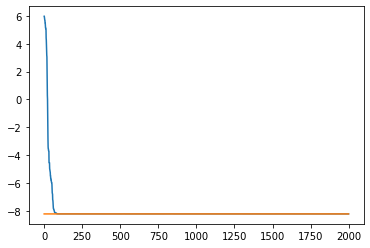

In [483]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [484]:
Nq

3

In [485]:
import pickle

file_to_store = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [486]:
import pickle

file_to_read = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

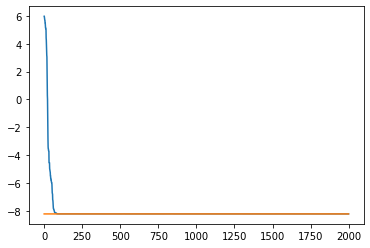

In [487]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

# GOMACTech Plots

In [211]:
import pickle

Nc = 1
Nq = 4
file_to_read = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")
loaded_object_14 = pickle.load(file_to_read)

Nc = 2
Nq = 3
file_to_read = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")
loaded_object_23 = pickle.load(file_to_read)

Nc = 3
Nq = 2
file_to_read = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")
loaded_object_32 = pickle.load(file_to_read)

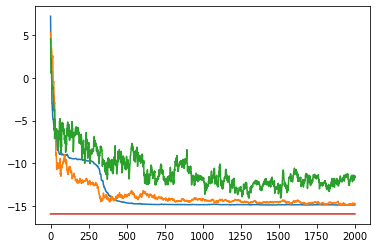

In [215]:
import matplotlib.pyplot as plt

El14 = [loaded_object_14[i]['E'] for i in range(len(loaded_object_14))]
El23 = [loaded_object_23[i]['E'] for i in range(len(loaded_object_23))]
El32 = [loaded_object_32[i]['E'] for i in range(len(loaded_object_32))]
tl = [i for i in range(len(El))]

plt.plot(tl,El14)
plt.plot(tl,El23)
plt.plot(tl,El32)
plt.plot(tl,E0)

In [488]:
Nc = 3
Nq = 3
file_to_read = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")
loaded_object_33 = pickle.load(file_to_read)

Nc = 2
Nq = 3
file_to_read = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")
loaded_object_23 = pickle.load(file_to_read)

Nc = 1
Nq = 3
file_to_read = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")
loaded_object_13 = pickle.load(file_to_read)

Nc = 0
Nq = 3
file_to_read = open("VQE_ByQubit_GOMACTech"+"_Nc_"+str(Nc)+"_Nq_"+str(Nq)+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")
loaded_object_03 = pickle.load(file_to_read)

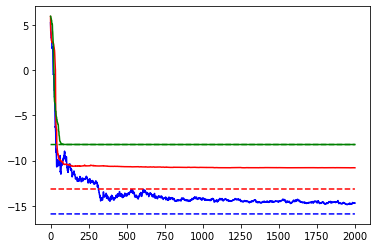

In [508]:
import matplotlib.pyplot as plt

El33 = [loaded_object_33[i]['E'] for i in range(len(loaded_object_33))]
El23 = [loaded_object_23[i]['E'] for i in range(len(loaded_object_23))]
El13 = [loaded_object_13[i]['E'] for i in range(len(loaded_object_13))]
El03 = [loaded_object_03[i]['E'] for i in range(len(loaded_object_03))]

tl = [i for i in range(len(El))]

#plt.plot(tl,El33, color = 'r')
#plt.plot(tl,E33, color = 'r')
plt.plot(tl,El23,'b')
plt.plot(tl,E23, 'b--')
plt.plot(tl,El13,'r')
plt.plot(tl,E13, 'r--')
plt.plot(tl,El03, 'g')
plt.plot(tl,E03, 'g--')

In [490]:
print(E33[0])
print(E23[0])
print(E13[0])
print(E03[0])

-20.426246166554296
-15.905891681476621
-13.147541728407505
-8.226181168649903


In [489]:
E03 = E0